### Objective of the project:

Every smart marketer knows the importance of knowing his or her customer well, before a product or service is marketed to the customer. This means that customers are segmented into smaller groups based on their customer trait before any marketing campaign is performed. One of the most popular segmentation methods is RFM segmentation. 

RFM stands for Recency, Frequency and Monetary value. These factors help in determining customers lifetime value. In general, more recent customers respond more to promotions, more frequent customers are generally satisfied with the product, and monetary value identifies spending capacity of customers.

The objective of this project is to cluster customers based on their RFM traits to improve marketing techniques and promotional offer for each customer.

#### Loading Data
- Loading necessary libraries to perform the analysis
- Loading the dataset required for the analysis and observing the data


In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import seaborn as sns
import numpy as np

In [2]:
df=pd.read_csv("Online Retail.csv")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:
df.shape

(541909, 8)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null object
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


#### Data Cleaning and Preprocessing

- It is understood that date is not specified as datetime object, converting it into dtype of datetime

In [5]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df.InvoiceDate = pd.to_datetime(df.InvoiceDate, format = "%d/%m/%y %H:%M")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


#### Missing and Negative Values

In [6]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


- Removing datapoints where quantity is lesser than zero

In [7]:
df = df[df.Quantity > 0]
df.shape

(531285, 8)

- Checking for null values in the dataset and removing such datapoints

In [8]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,531285.000000,531285.000000,397924.000000
mean,10.655262,3.857296,15294.315171
std,156.830323,41.810047,1713.169877
min,1.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13969.000000
50%,3.000000,2.080000,15159.000000
75%,10.000000,4.130000,16795.000000
max,80995.000000,13541.330000,18287.000000


In [9]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description       592
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     133361
Country             0
dtype: int64

In [10]:
df.dropna(inplace = True) 
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [11]:
df.shape

(397924, 8)

- Assigning customers a rank based on their purchases from 1 to 4, with rank 1 indicating more items bought and rank 4 less items bought

In [12]:
def rank(x):
    if(x>=15):
        return 1
    elif(x>=7):
        return 2
    elif(x>=3):
        return 3
    else:
        return 4
    
df['rank'] = df['Quantity'].apply(rank)

- Observing number of customers within each rank

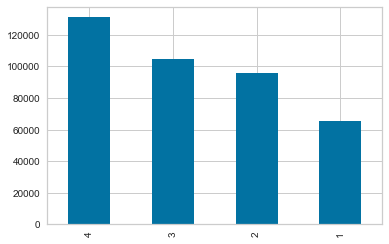

In [13]:
df['rank'].value_counts().plot(kind='bar');

- Aggregagting customers on the total amount they have spent to create a variable called *Amount*

In [14]:
df['Amount'] = df["Quantity"] * df["UnitPrice"]

In [15]:
monetary = df.groupby("CustomerID").Amount.sum()
monetary=monetary.reset_index()
monetary.head()

,CustomerID,Amount
0,12346.0,77183.60
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


- Aggregagting customers on the total number of invoices they have  to create a variable called *Frequency*

In [16]:
frequency = df.groupby("CustomerID").InvoiceNo.count()
frequency = frequency.reset_index()
frequency.head(10)

,CustomerID,InvoiceNo
0,12346.0,1
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17
5,12352.0,85
6,12353.0,4
7,12354.0,58
8,12355.0,13
9,12356.0,59


- Aggregating customers on their last invoice date to create a variable called *recency*

In [17]:
maximum = max(df.InvoiceDate)
maximum = maximum + pd.DateOffset(days=1)
#Offsetting by 1 day to avoid zero


df['Diff'] = maximum - df.InvoiceDate

recency = df.groupby('CustomerID').Diff.min()
recency = recency.reset_index()
recency.head()


,CustomerID,Diff
0,12346.0,326 days 02:49:00
1,12347.0,2 days 20:58:00
2,12348.0,75 days 23:37:00
3,12349.0,19 days 02:59:00
4,12350.0,310 days 20:49:00


#### Merging *frequency*, *monetary*, *recency* on *CustomerID* to create a new dataframe

In [18]:
final_df = frequency.merge(monetary, on = "CustomerID")
final_df = final_df.merge(recency, on = "CustomerID")
final_df.head()

,CustomerID,InvoiceNo,Amount,Diff
0,12346.0,1,77183.60,326 days 02:49:00
1,12347.0,182,4310.00,2 days 20:58:00
2,12348.0,31,1797.24,75 days 23:37:00
3,12349.0,73,1757.55,19 days 02:59:00
4,12350.0,17,334.40,310 days 20:49:00


- Renaming the columns as Frequency, Amount and Recency

In [19]:
print(final_df.shape)
final_df.columns = ["CustomerID", "Frequency","Amount","Recency"]
final_df.Recency = final_df.Recency.dt.days
final_df=final_df.reset_index(drop=True)
final_df.head()

(4339, 4)


,CustomerID,Frequency,Amount,Recency
0,12346.0,1,77183.60,326
1,12347.0,182,4310.00,2
2,12348.0,31,1797.24,75
3,12349.0,73,1757.55,19
4,12350.0,17,334.40,310


In [20]:
final_df.shape

(4339, 4)

#### Outlier Treatment
- Checking for outliers and removing if any, in the newly created columns
- Using Interquartile Range: 
    <br> data points below  Q1-1.5 IQR and points above Q3+1.5 IQR are removed

- Outliers in Frequency

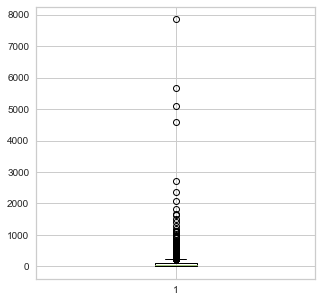

In [21]:
plt.figure(figsize=(5, 5))
plt.boxplot(final_df['Frequency']);

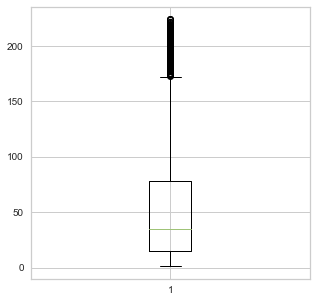

In [22]:
Q1 = final_df['Frequency'].quantile(0.25)
Q3 = final_df['Frequency'].quantile(0.75)
IQR = Q3 - Q1
final_df = final_df[(final_df['Frequency'] >= Q1 - 1.5*IQR) & (final_df['Frequency'] <= Q3 + 1.5*IQR)]
plt.figure(figsize=(5, 5))
plt.boxplot(final_df['Frequency']);

- Outliers in Amount

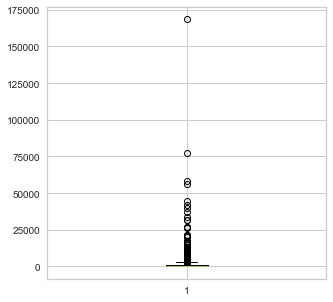

In [23]:
plt.figure(figsize=(5, 5))
plt.boxplot(final_df['Amount']);

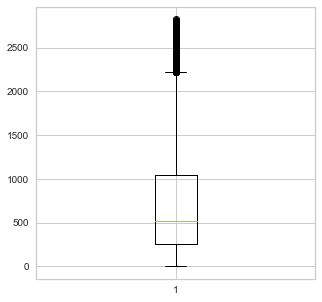

In [24]:
Q1 = final_df['Amount'].quantile(0.25)
Q3 = final_df['Amount'].quantile(0.75)
IQR = Q3 - Q1
final_df = final_df[(final_df['Amount'] >= Q1 - 1.5*IQR) & (final_df['Amount'] <= Q3 + 1.5*IQR)]
plt.figure(figsize=(5, 5))
plt.boxplot(final_df['Amount']);

- Outliers in Recency

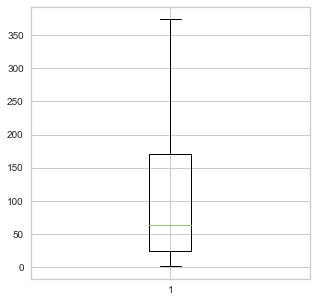

In [25]:
plt.figure(figsize=(5, 5))
plt.boxplot(final_df['Recency']);

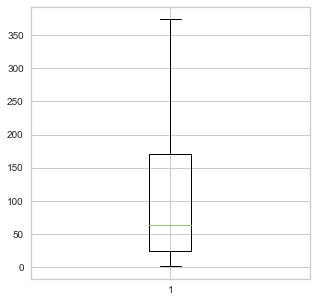

In [26]:
Q1 = final_df['Recency'].quantile(0.25)
Q3 = final_df['Recency'].quantile(0.75)
IQR = Q3 - Q1
final_df = final_df[(final_df['Recency'] >= Q1 - 1.5*IQR) & (final_df['Recency'] <= Q3 + 1.5*IQR)]
plt.figure(figsize=(5, 5))
plt.boxplot(final_df['Recency']);

In [27]:
final_df.shape

(3630, 4)

In [28]:
final_df=final_df.reset_index(drop=True)
final_df

,CustomerID,Frequency,Amount,Recency
0,12348.0,31,1797.24,75
1,12349.0,73,1757.55,19
2,12350.0,17,334.40,310
3,12352.0,85,2506.04,36
4,12353.0,4,89.00,204
...,...,...,...,...
3625,18278.0,9,173.90,74
3626,18280.0,10,180.60,278
3627,18281.0,7,80.82,181
3628,18282.0,12,178.05,8


- Dropping CustomerID

In [29]:
data=final_df.drop("CustomerID", axis=1)
data=data.reset_index(drop=True)
data

,Frequency,Amount,Recency
0,31,1797.24,75
1,73,1757.55,19
2,17,334.40,310
3,85,2506.04,36
4,4,89.00,204
...,...,...,...
3625,9,173.90,74
3626,10,180.60,278
3627,7,80.82,181
3628,12,178.05,8


#### Normalisation of data

- Since the features have different scales, it is essential that data is normalised before it used for model building process
- StandardScaler from sklearn is used for the same
- Standardize features by removing the mean and scaling to unit variance
- The standard score of a sample x is calculated as:
  <br> *z = (x - u)/s*
  <br>where *u* is  mean and *s* is the standard deviation 

In [30]:
standard_scaler = StandardScaler()
data_norm = standard_scaler.fit_transform(data)
data_norm

array([[-0.36565146,  1.6326323 , -0.29015513],
       [ 0.58286609,  1.57106235, -0.83345935],
       [-0.68182398, -0.63662888,  1.9897822 ],
       ...,
       [-0.90766149, -1.03000017,  0.73824213],
       [-0.79474274, -0.87917009, -0.94017982],
       [ 0.51511484,  1.69474519, -0.60061468]])

In [31]:
data.shape

(3630, 3)

In [32]:
data_norm.shape

(3630, 3)

- Converting the normalized data to a dataframe object

In [33]:
data_norm=pd.DataFrame(data=data_norm)
data_norm=data_norm.reset_index(drop=True)
data_norm.columns = ["Frequency","Amount","Recency"]
data_norm

,Frequency,Amount,Recency
0,-0.365651,1.632632,-0.290155
1,0.582866,1.571062,-0.833459
2,-0.681824,-0.636629,1.989782
3,0.853871,2.732173,-0.668528
4,-0.975413,-1.017311,0.961385
...,...,...,...
3625,-0.862494,-0.885608,-0.299857
3626,-0.839910,-0.875214,1.679323
3627,-0.907661,-1.030000,0.738242
3628,-0.794743,-0.879170,-0.940180


#### Clustering Methods

#### Dendogram

- The dendrogram illustrates how each cluster is composed by drawing a U-shaped link between a non-singleton cluster and its children. 
- The top of the U-link indicates a cluster merge. 
- The two legs of the U-link indicate which clusters were merged. 
- The length of the two legs of the U-link represents the distance between the child clusters. It is also the cophenetic distance between original observations in the two children clusters.

- Method complete is used to calculate distance which is 
    <br>*d(u, v)= max(dist($u_{[i]}$, $v_{[j]}$))*
   <br>for all points *i* in cluster *u* and  *j* in cluster *v* . This is also known by the Farthest Point Algorithm or Voor Hees  Algorithm.
- Metric used is Euclidean distance.
    

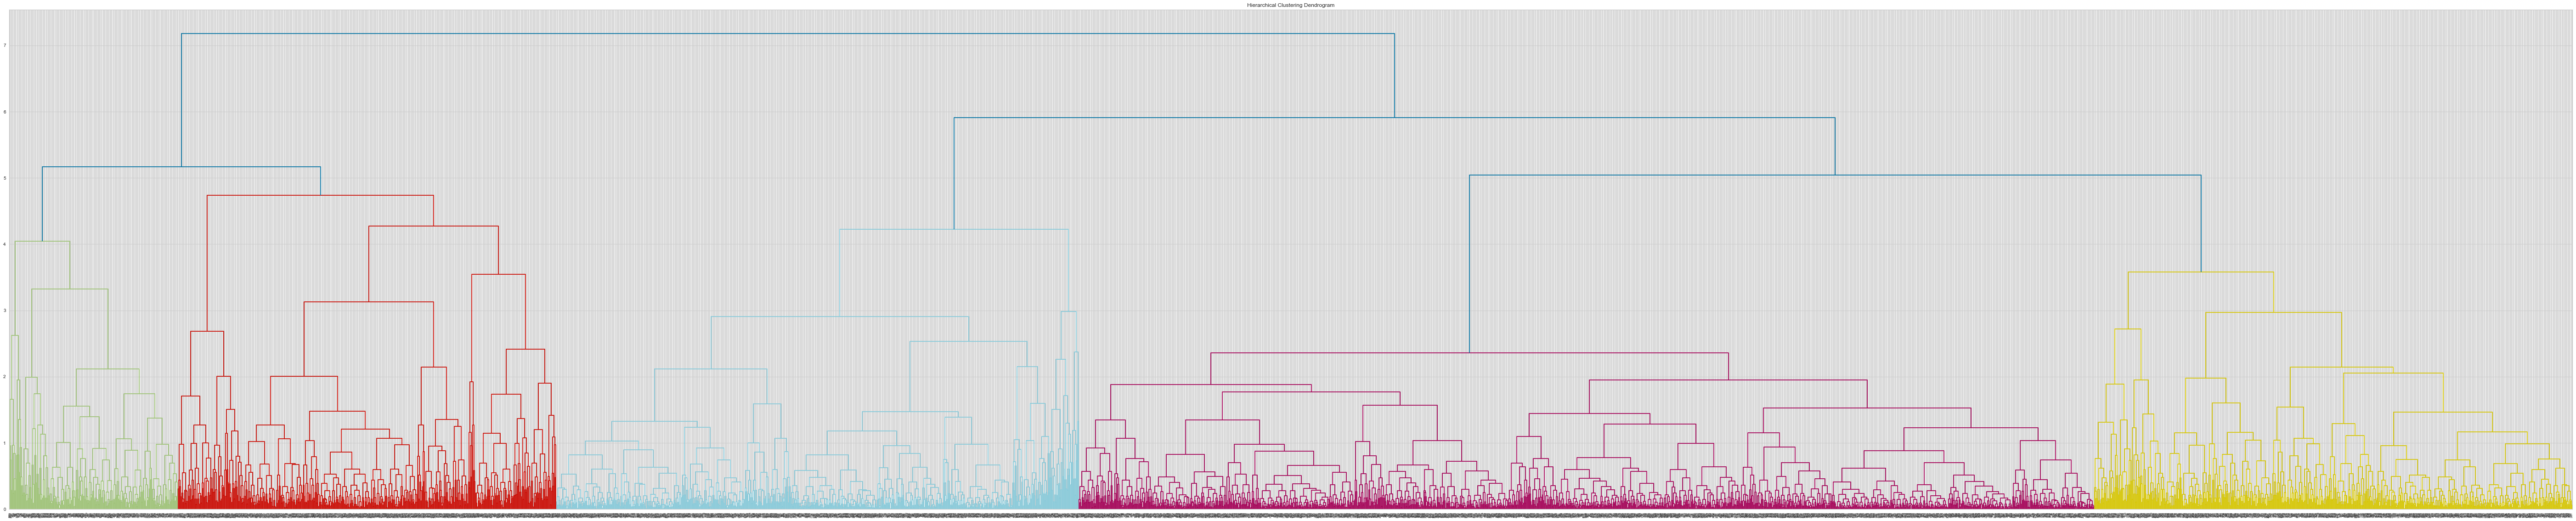

In [34]:
plt.figure(figsize=(100, 20))
plt.title('Hierarchical Clustering Dendrogram')
final_dendogram = linkage(data_norm, method = "complete", metric='euclidean')
dendrogram(final_dendogram)
plt.show()

- From the dendogram, number of clusters have been selected as 3.
- Maxclust finds a minimum threshold r so that the cophenetic distance between any two original observations in the same flat cluster is no more than r and no more than t flat clusters are formed.

In [35]:
k=3
dend_clusters= fcluster(final_dendogram, k, criterion='maxclust')
dend_clusters

array([3, 3, 2, ..., 3, 3, 3], dtype=int32)

- Assigning clusters to each customer

In [36]:
dendogram_clusters = pd.concat([final_df, pd.Series(dend_clusters)], axis=1)
dendogram_clusters=dendogram_clusters.rename(columns={0:"Cluster"})
dendogram_clusters

,CustomerID,Frequency,Amount,Recency,Cluster
0,12348.0,31,1797.24,75,3
1,12349.0,73,1757.55,19,3
2,12350.0,17,334.40,310,2
3,12352.0,85,2506.04,36,3
4,12353.0,4,89.00,204,3
...,...,...,...,...,...
3625,18278.0,9,173.90,74,3
3626,18280.0,10,180.60,278,2
3627,18281.0,7,80.82,181,3
3628,18282.0,12,178.05,8,3


- Calculating number of customers in each cluster

In [37]:
dendogram_clusters.groupby(["Cluster"]).Cluster.count()

Cluster
1     775
2     740
3    2115
Name: Cluster, dtype: int64

- Plotting the clusters to find out how each customer is segmented

<Figure size 432x288 with 0 Axes>

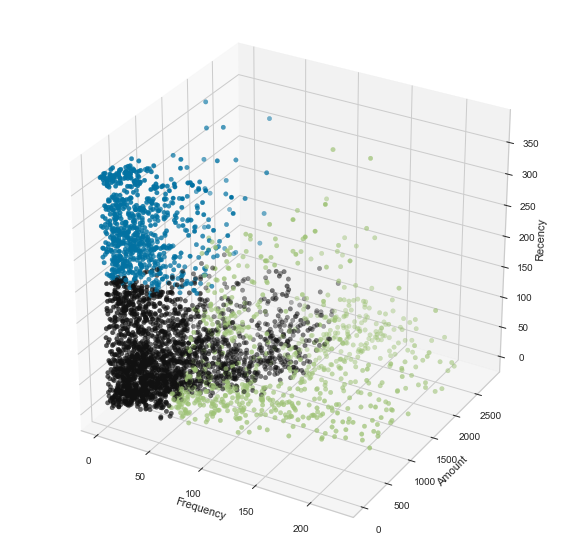

In [38]:
fig = plt.figure()
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
colormap = np.array(['r', 'g', 'b','k'])

ax.scatter(xs=dendogram_clusters.Frequency, ys=dendogram_clusters.Amount, zs=dendogram_clusters.Recency, c=colormap[dendogram_clusters.Cluster])
#ax.scatter(xs = Agglomerative_clusters.Frequency,ys = Agglomerative_clusters.Amount, zs =  Agglomerative_clusters.Recency, c=colormap[Agglomerative_clusters.Cluster])

ax.set_xlabel('Frequency')
ax.set_ylabel('Amount')
ax.set_zlabel('Recency')
plt.show();

#### Agglomerative Clustering
- Agglomerative clustering is a strategy of hierarchical clustering. Hierarchical clustering is a method of cluster analysis which seeks to build a hierarchy of clusters. It is based on the core idea of objects being more related to nearby objects than to objects farther away.
- Agglomerative clustering works in a “bottom-up” manner. Each observation starts in its own cluster, and pairs of clusters are merged as one moves up the hierarchy.
- Choosing 3 clusters as the dataset is not huge.

In [39]:
hierarchical = AgglomerativeClustering(n_clusters = 3, affinity= 'euclidean',linkage ='complete')
hirar_clusters = hierarchical.fit_predict(data_norm)
hirar_clusters

array([1, 1, 2, ..., 1, 1, 1], dtype=int64)

In [40]:
len(hirar_clusters)

3630

In [41]:
len(final_df)

3630

- Assigning clusters to each customer

In [42]:
Agglomerative_clusters = pd.concat([final_df, pd.Series(hirar_clusters)], axis=1)
Agglomerative_clusters=Agglomerative_clusters.rename(columns={0:"Cluster"})
Agglomerative_clusters.head()

,CustomerID,Frequency,Amount,Recency,Cluster
0,12348.0,31,1797.24,75,1
1,12349.0,73,1757.55,19,1
2,12350.0,17,334.40,310,2
3,12352.0,85,2506.04,36,1
4,12353.0,4,89.00,204,1


- Calculating the number of customers in each cluster

In [43]:
Agglomerative_clusters.groupby(["Cluster"]).Cluster.count()

Cluster
0     775
1    2115
2     740
Name: Cluster, dtype: int64

- Plotting the clusters to find out how each customer is segmented

<Figure size 432x288 with 0 Axes>

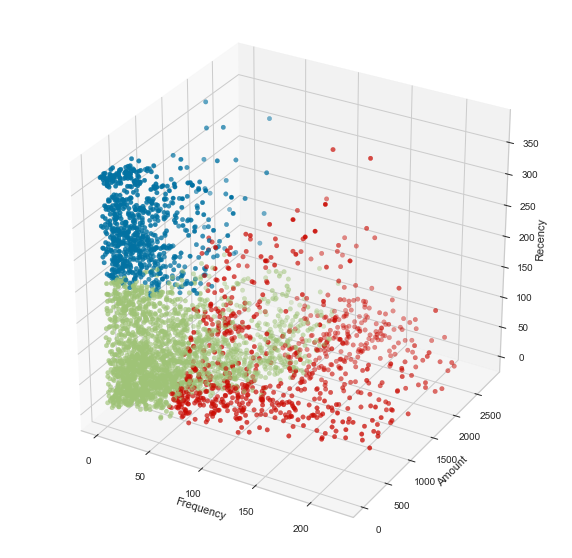

In [44]:

fig = plt.figure()
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
colormap = np.array(['r', 'g', 'b'])
ax.scatter(xs = Agglomerative_clusters.Frequency,ys = Agglomerative_clusters.Amount, zs =  Agglomerative_clusters.Recency, c=colormap[Agglomerative_clusters.Cluster])

ax.set_xlabel('Frequency')
ax.set_ylabel('Amount')
ax.set_zlabel('Recency')
plt.show();

#### K-means Clustering

- K-means clustering is one of the simplest and popular unsupervised machine learning algorithms.
- The objective of K-means is simple: group similar data points together and discover underlying patterns. To achieve this objective, K-means looks for a fixed number (k) of clusters in a dataset.
- To process the learning data, the K-means algorithm in data mining starts with a first group of randomly selected centroids, which are used as the beginning points for every cluster, and then performs iterative (repetitive) calculations to optimize the positions of the centroids
- It halts creating and optimizing clusters when either:
    <br>The centroids have stabilized — there is no change in their values because the clustering has been successful.
    <br>The defined number of iterations has been achieved.

#### Elbow Visualizer
- The KElbowVisualizer implements the “elbow” method to  select the optimal number of clusters by fitting the model with a range of values for K. 
- If the line chart resembles an arm, then the “elbow” (the point of inflection on the curve) is a good indication that the underlying model fits best at that point. 
- By default, the scoring parameter metric is set to distortion, which computes the sum of squared distances from each point to its assigned center. 

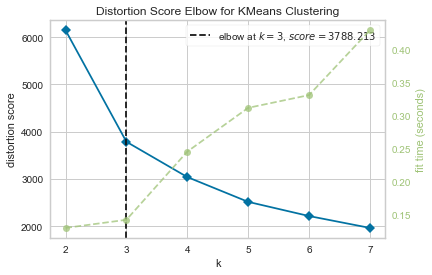

In [45]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,8))

visualizer.fit(data_norm)   
visualizer.show() ; 

- The optimal number of clusters is identified as 3.
- Customers are assigned into one of the clusters formed.

In [46]:
km_model = KMeans(n_clusters=3)
km_model.fit(data_norm)

kmeans_cluster_3 = pd.concat([final_df, pd.Series(km_model.labels_)], axis=1)
kmeans_cluster_3=kmeans_cluster_3.rename(columns={0:"Cluster"})
kmeans_cluster_3

,CustomerID,Frequency,Amount,Recency,Cluster
0,12348.0,31,1797.24,75,2
1,12349.0,73,1757.55,19,2
2,12350.0,17,334.40,310,1
3,12352.0,85,2506.04,36,2
4,12353.0,4,89.00,204,1
...,...,...,...,...,...
3625,18278.0,9,173.90,74,0
3626,18280.0,10,180.60,278,1
3627,18281.0,7,80.82,181,1
3628,18282.0,12,178.05,8,0


- Calculating number of customers in each cluster

In [47]:
kmeans_cluster_3.groupby(["Cluster"]).Cluster.count()

Cluster
0    1850
1     949
2     831
Name: Cluster, dtype: int64

- Plotting the clusters to find out how each customer is segmented

<Figure size 432x288 with 0 Axes>

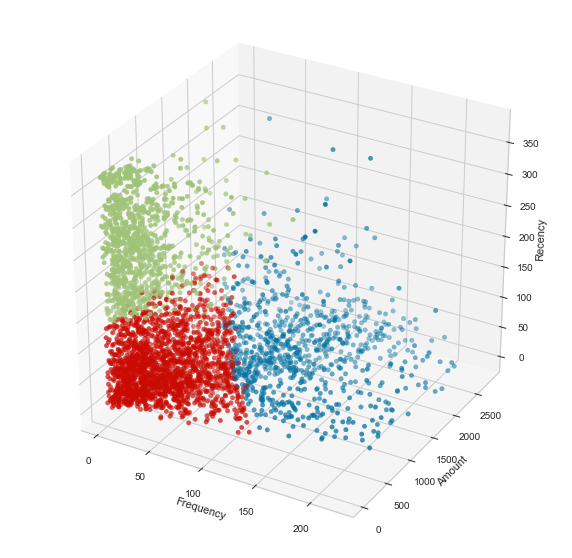

In [48]:

fig = plt.figure()
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
colormap = np.array(['r', 'g', 'b'])
ax.scatter(xs = kmeans_cluster_3.Frequency,ys = kmeans_cluster_3.Amount, zs =  kmeans_cluster_3.Recency, c=colormap[kmeans_cluster_3.Cluster])

ax.set_xlabel('Frequency')
ax.set_ylabel('Amount')
ax.set_zlabel('Recency')
plt.show();

- Attempting 5 clusters to see the performance of the model

In [49]:
km_model = KMeans(n_clusters=5)
km_model.fit(data_norm)

kmeans_cluster_5 = pd.concat([final_df, pd.Series(km_model.labels_)], axis=1)
kmeans_cluster_5=kmeans_cluster_5.rename(columns={0:"Cluster"})
kmeans_cluster_5

,CustomerID,Frequency,Amount,Recency,Cluster
0,12348.0,31,1797.24,75,3
1,12349.0,73,1757.55,19,1
2,12350.0,17,334.40,310,2
3,12352.0,85,2506.04,36,1
4,12353.0,4,89.00,204,2
...,...,...,...,...,...
3625,18278.0,9,173.90,74,0
3626,18280.0,10,180.60,278,2
3627,18281.0,7,80.82,181,2
3628,18282.0,12,178.05,8,0


- Calculating number of customers in each cluster

In [50]:
kmeans_cluster_5.groupby(["Cluster"]).Cluster.count()

Cluster
0    1269
1     411
2     896
3     835
4     219
Name: Cluster, dtype: int64

- Plotting the clusters to find out how each customer is segmented

<Figure size 432x288 with 0 Axes>

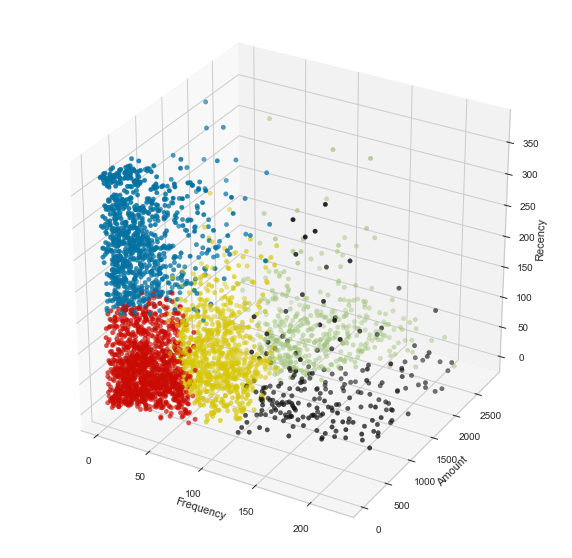

In [51]:
fig = plt.figure()
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
colormap = np.array(['r', 'g', 'b', 'y','k', 'm'])
ax.scatter(xs = kmeans_cluster_5.Frequency,ys = kmeans_cluster_5.Amount, zs =  kmeans_cluster_5.Recency, c=colormap[kmeans_cluster_5.Cluster])

ax.set_xlabel('Frequency')
ax.set_ylabel('Amount')
ax.set_zlabel('Recency')
plt.show();

#### Analysis of Models

- K-Means with 3 clusters performed better of all the models created
- Further analysis shall be done on the reults of the same
- Mean of Amount, Frequency and Recency of each cluster is calculated


In [52]:
kmeans_clusters_amount = pd.DataFrame(kmeans_cluster_3.groupby(["Cluster"]).Amount.mean())
kmeans_clusters_frequency = pd.DataFrame(kmeans_cluster_3.groupby(["Cluster"]).Frequency.mean())
kmeans_clusters_recency = pd.DataFrame(kmeans_cluster_3.groupby(["Cluster"]).Recency.mean())

- Calculated mean values are tabulated into a dataframe

In [53]:
kmeans_Mean = pd.concat([pd.Series([1,2,3]), kmeans_clusters_amount, kmeans_clusters_frequency, kmeans_clusters_recency], axis=1)
kmeans_Mean.columns = ["ClusterID", "mean_amount", "mean_frequency", "mean_recency"]
kmeans_Mean.head()

,ClusterID,mean_amount,mean_frequency,mean_recency
0,1,538.828769,32.604865,53.632432
1,2,355.372592,21.186512,256.139094
2,3,1648.029410,109.359807,46.350181


- Calculated mean of Amount is plotted against each Cluster

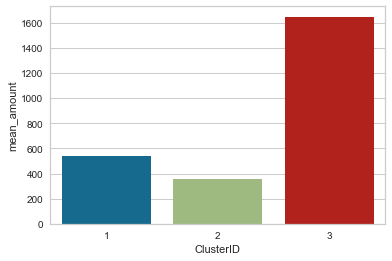

In [54]:
sns.barplot(x=kmeans_Mean.ClusterID, y=kmeans_Mean.mean_amount);

- Calculated mean of Frequency is plotted against each Cluster

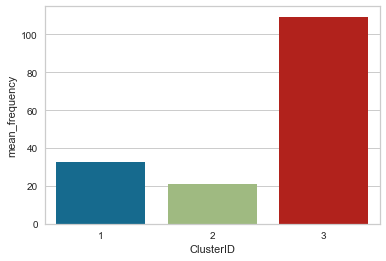

In [55]:
sns.barplot(x=kmeans_Mean.ClusterID, y=kmeans_Mean.mean_frequency);

- Calculated mean of Recency is plotted against each Cluster

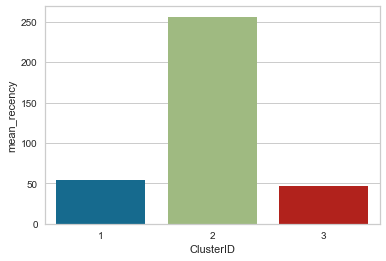

In [56]:
sns.barplot(x=kmeans_Mean.ClusterID, y=kmeans_Mean.mean_recency);

### Recommendations:

- Customers in cluster 2 can be given loyalty programs as they spend more amount than those in  cluster 1 and 3.
- Customers in cluster 1 and 3 less frequent. Therfore, they should be attracted to buy more often with new marketing strategies such as targeted email campaigns
- Customers in cluster 3 have not made any recent purchase. They can be attarcted with discount coupons that come with expiry stamp.

#### References:

https://docs.rapidminer.com/latest/studio/operators/modeling/segmentation/agglomerative_clustering.html
http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html
https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html
https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html                                     
https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1                               
https://www.scikit-yb.org/en/latest/api/cluster/elbow.html